In [24]:
import os 
import glob
import math
import random
import base64
from tqdm import tqdm
from pathlib import Path

import cv2
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw2
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image
from uniface import YOLOv5Face, RetinaFace, SCRFD, YOLOv8Face


ROOT_DIR  = Path("../").resolve()
DATA_DIR = ROOT_DIR / "data"
TEST_DIR = DATA_DIR / "test_data"

## Utils

In [2]:
def get_base64_image(image_path):
    """
    Reads an image file and converts it to a base64 encoded string.
    """
    try:
        with open(image_path, "rb") as image_file:
            # 1. Read binary data
            binary_data = image_file.read()
            
            # 2. Encode to base64
            base64_encoded = base64.b64encode(binary_data).decode('utf-8')
            
            # 3. Determine the file extension for the Data URI prefix
            ext = Path(image_path).suffix.lower().replace('.', '')
            if ext == 'jpg': ext = 'jpeg'
            
            # 4. Return the full Data URI (useful for HTML/Notebooks)
            return f"data:image/{ext};base64,{base64_encoded}"
            
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None


def get_random_index(n_images: int) -> int:
    return random.randint(0, n_images - 1)

In [3]:
image_paths = glob.glob(str(TEST_DIR / 'crowd_counting' / 'test' / "*.jpg"))
len(image_paths)

231

/home/octoopt/workspace/projects/learn-from-basics/compvision_learning/data/test_data/crowd_counting/test/img_133_jpg.rf.7f778a9cea2d5abaf72ef5e66590e91c.jpg


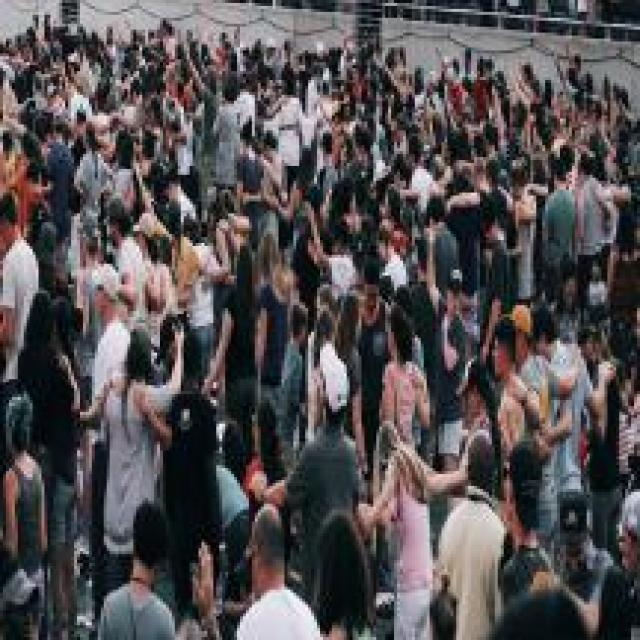

In [57]:
sample_path = image_paths[get_random_index(len(image_paths))]
print(sample_path)
Image.open(sample_path)

## Evaluation of Face Detectors

In [58]:

# Method-1, use FaceAnalysis
app = FaceAnalysis(allowed_modules=['detection']) # enable detection model only
app.prepare(ctx_id=0, det_size=(640, 640))



Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
model ignore: /home/octoopt/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecuti

In [ ]:
import numpy as np
# Patch np.int if it's missing (helps with old libraries)
if not hasattr(np, 'int'):
    np.int = int
    np.float = float
    np.bool = bool

img = cv2.imread(sample_path)
faces = app.get(img)
rimg = app.draw_on(img, faces)


True

In [ ]:
yolo5_detector = YOLOv5Face()
retina_detector = RetinaFace()
scrfd_detector = SCRFD()
yolo8_detector = YOLOv8Face()

In [ ]:
# 1. Setup InsightFace
ins_detector = FaceAnalysis(providers=['CUDAExecutionProvider', 'CPUExecutionProvider'], allowed_modules=['detection'])
ins_detector.prepare(ctx_id=0, det_size=(640, 640))

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
model ignore: /home/octoopt/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecuti

In [20]:
img = cv2.imread(sample_path)

yolo5_faces = yolo5_detector.detect(image=img)
retina_faces = retina_detector.detect(image=img)
scrfd_faces = scrfd_detector.detect(image=img)
yolo8_faces = yolo8_detector.detect(image=img)

ins_faces = ins_detector.get(img)

In [21]:
def draw_faces(image, faces, color=(0, 255, 0)):
    """ 
    Draws bounding boxes, landmarks, and confidence.
    Compatible with Uniface and InsightFace.
    """
    res_img = image.copy()
    
    for face in faces:
        # 1. Handle Bounding Box (Ensure we only take first 4 values)
        bbox = face.bbox[:4].astype(int)
        cv2.rectangle(res_img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 2)
        
        # 2. Handle Confidence Score (Check for different attribute names)
        conf = getattr(face, 'confidence', None)
        if conf is None:
            conf = getattr(face, 'det_score', 0.0)
            
        label = f"{conf:.2f}"
        cv2.putText(res_img, label, (bbox[0], bbox[1] - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        
        # 3. Handle Landmarks (Uniface .landmarks vs InsightFace .kps)
        landmarks = getattr(face, 'landmarks', None)
        if landmarks is None:
            landmarks = getattr(face, 'kps', None)

        if landmarks is not None:
            for lmk in landmarks.astype(int):
                # Draw small circles for the face keys (eyes, nose, etc.)
                cv2.circle(res_img, (lmk[0], lmk[1]), 2, (0, 0, 255), -1)
                
    return res_img


# Get the annotated images
# BGR Colors
COLORS = {
    'yolo5':   (0, 255, 0),     # Green
    'retina':  (255, 0, 0),     # Blue
    'scrfd':   (0, 255, 255),   # Cyan
    'yolo8':   (255, 165, 0),   # Orange
    'insight': (255, 0, 255)    # Magenta
}

# Generate Annotated Images
img_yolo5   = draw_faces(img, yolo5_faces,   color=COLORS['yolo5'])
img_retina  = draw_faces(img, retina_faces,  color=COLORS['retina'])
img_scrfd   = draw_faces(img, scrfd_faces,   color=COLORS['scrfd'])
img_yolo8   = draw_faces(img, yolo8_faces,   color=COLORS['yolo8'])
img_insight = draw_faces(img, ins_faces,     color=COLORS['insight'])

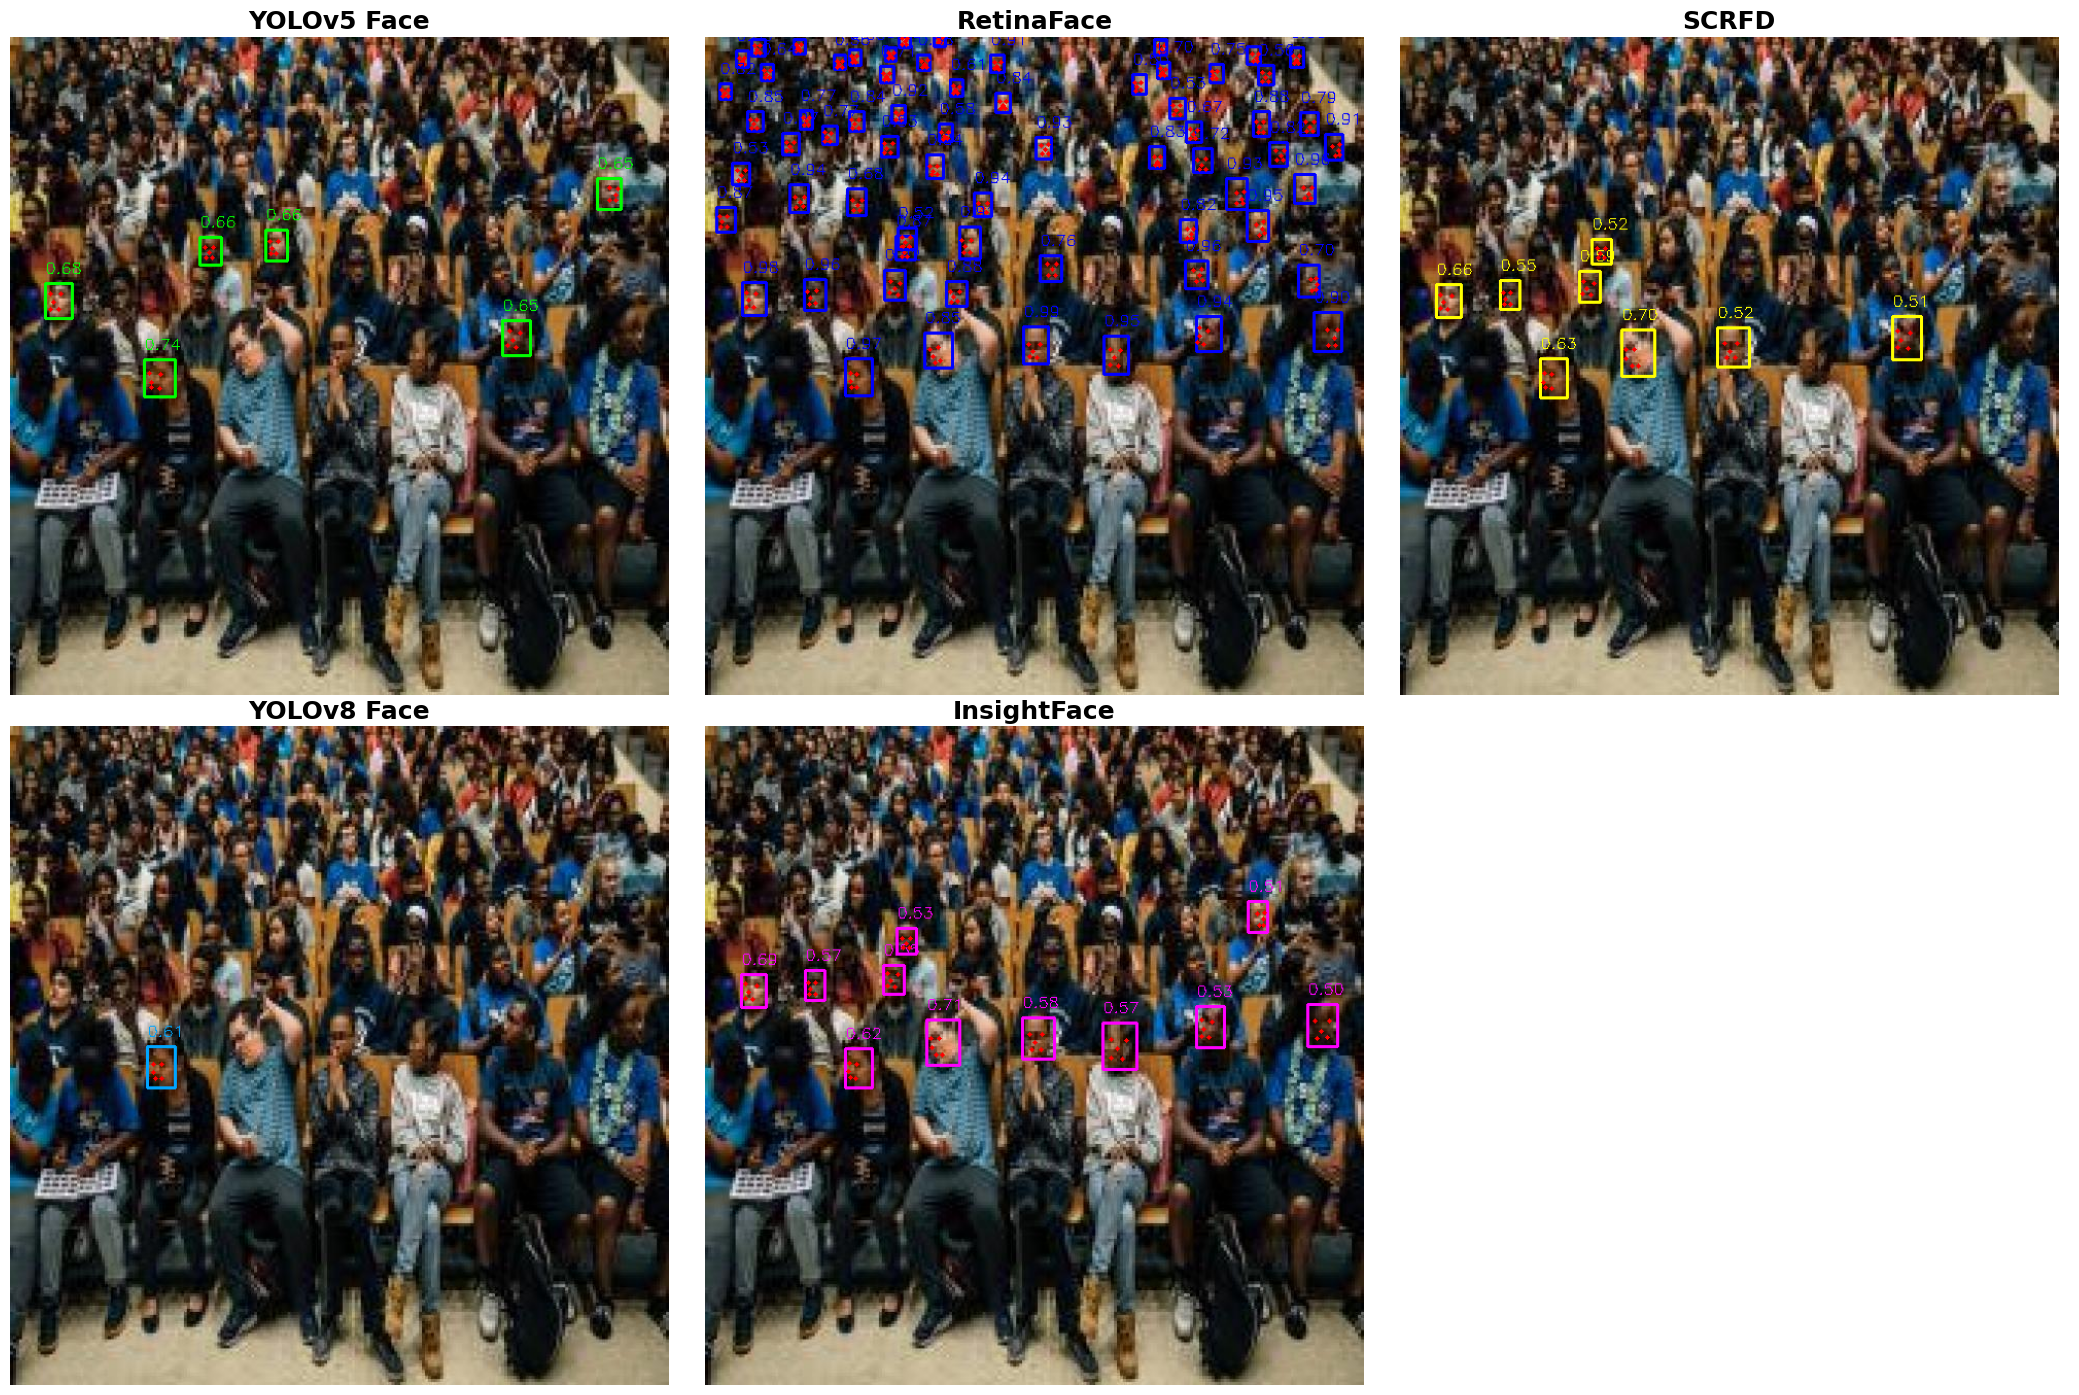

In [25]:

# 1. Your data
titles = ['YOLOv5 Face', 'RetinaFace', 'SCRFD', 'YOLOv8 Face', 'InsightFace']
images = [img_yolo5, img_retina, img_scrfd, img_yolo8, img_insight]

# 2. ADAPTIVE CONFIG: Change 'n_cols' to whatever you prefer
n_cols = 3 
n_images = len(images)
n_rows = math.ceil(n_images / n_cols)

# 3. Create the grid
# figsize is scaled: (width, height)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 7, n_rows * 7))

# Ensure axes is a flat array even if it's 1 row or 1 image
if n_images == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# 4. Fill the grid
for i in range(len(axes)):
    if i < n_images:
        # Convert and Show
        axes[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        axes[i].set_title(titles[i], fontsize=18, fontweight='bold')
        axes[i].axis('off')
    else:
        # Hide any unused subplots (e.g., if you have 5 images in a 3x2 grid)
        axes[i].axis('off')

plt.tight_layout()
plt.show()

In [26]:
def load_yolo_labels(label_path, img_w, img_h):
    """Parses YOLO .txt and returns absolute [x1, y1, x2, y2] boxes."""
    boxes = []
    if not os.path.exists(label_path):
        return np.array([])
        
    with open(label_path, 'r') as f:
        for line in f:
            # YOLO: class x_center y_center width height (normalized)
            cls, cx, cy, w, h = map(float, line.strip().split())
            
            # Convert to absolute pixel coordinates [x1, y1, x2, y2]
            x1 = (cx - w/2) * img_w
            y1 = (cy - h/2) * img_h
            x2 = (cx + w/2) * img_w
            y2 = (cy + h/2) * img_h
            boxes.append([x1, y1, x2, y2])
            
    return np.array(boxes)

def calculate_iou(boxA, boxB):
    """Calculates Intersection over Union (IoU) between two boxes."""
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    return interArea / float(boxAArea + boxBArea - interArea)


def evaluate_detector(detector, test_dir, iou_threshold=0.3):
    """
    Evaluates detector performance. 
    Compatible with both Uniface (.detect()) and InsightFace (.get()) models.
    """
    test_path = Path(test_dir)
    image_files = list(test_path.glob("*.jpg"))
    
    results = {'total_gt': 0, 'total_dt': 0, 'mae_list': [], 'matches': 0}
    
    for img_p in tqdm(image_files, desc="Evaluating"):
        img = cv2.imread(str(img_p))
        if img is None: continue
        h, w = img.shape[:2]
        gt_boxes = load_yolo_labels(img_p.with_suffix('.txt'), w, h)
        
        # --- Handle different model APIs ---
        if hasattr(detector, 'detect'):
            # Uniface style
            detected_faces = detector.detect(img)
        elif hasattr(detector, 'get'):
            # InsightFace style
            detected_faces = detector.get(img)
        else:
            raise AttributeError("Model must have a .detect() or .get() method")
            
        # Extract bounding boxes (InsightFace and Uniface both use .bbox property)
        dt_boxes = [face.bbox[:4] for face in detected_faces] 
        
        results['total_gt'] += len(gt_boxes)
        results['total_dt'] += len(dt_boxes)
        results['mae_list'].append(abs(len(gt_boxes) - len(dt_boxes)))
        
        matched_gt = set()
        for dt_box in dt_boxes:
            for i, gt_box in enumerate(gt_boxes):
                if i not in matched_gt and calculate_iou(dt_box, gt_box) > iou_threshold:
                    matched_gt.add(i)
                    results['matches'] += 1
                    break
                    
    # Metrics
    mae = np.mean(results['mae_list'])
    recall = results['matches'] / results['total_gt'] if results['total_gt'] > 0 else 0
    precision = results['matches'] / results['total_dt'] if results['total_dt'] > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        "MAE": round(mae, 2),
        "F1 Score": round(f1, 4),
        "Recall": f"{recall:.2%}",
        "Precision": f"{precision:.2%}",
        "GT Count": results['total_gt'],
        "DT Count": results['total_dt']
    }

In [27]:

test_dir = TEST_DIR / 'crowd_counting' / 'valid'
iou_threshold = 0.3

# Evaluate
print("Evaluating YOLOv5Face:")
print(evaluate_detector(yolo5_detector, test_dir=str(test_dir), iou_threshold=iou_threshold))

print("\nEvaluating RetinaFace:")
print(evaluate_detector(retina_detector, test_dir=str(test_dir), iou_threshold=iou_threshold))

print("\nEvaluating SCRFD:")
print(evaluate_detector(scrfd_detector, test_dir=str(test_dir), iou_threshold=iou_threshold))

print("\nEvaluating YOLOv8Face:")
print(evaluate_detector(yolo8_detector, test_dir=str(test_dir), iou_threshold=iou_threshold))


print("\nEvaluating InsightFace Performance:")
print(evaluate_detector(ins_detector, test_dir=str(test_dir), iou_threshold=iou_threshold))

Evaluating YOLOv5Face:


Evaluating: 100%|██████████| 382/382 [00:12<00:00, 30.62it/s]


{'MAE': np.float64(189.6), 'F1 Score': 0.0345, 'Recall': '1.75%', 'Precision': '99.01%', 'GT Count': 73736, 'DT Count': 1307}

Evaluating RetinaFace:


Evaluating: 100%|██████████| 382/382 [00:17<00:00, 22.04it/s]


{'MAE': np.float64(172.58), 'F1 Score': 0.1783, 'Recall': '9.86%', 'Precision': '93.00%', 'GT Count': 73736, 'DT Count': 7816}

Evaluating SCRFD:


Evaluating: 100%|██████████| 382/382 [00:11<00:00, 32.03it/s]


{'MAE': np.float64(186.9), 'F1 Score': 0.0604, 'Recall': '3.12%', 'Precision': '98.16%', 'GT Count': 73736, 'DT Count': 2342}

Evaluating YOLOv8Face:


Evaluating: 100%|██████████| 382/382 [00:08<00:00, 43.62it/s]


{'MAE': np.float64(189.75), 'F1 Score': 0.0329, 'Recall': '1.67%', 'Precision': '98.40%', 'GT Count': 73736, 'DT Count': 1253}

Evaluating InsightFace Performance:


Evaluating: 100%|██████████| 382/382 [00:11<00:00, 32.71it/s]

{'MAE': np.float64(186.19), 'F1 Score': 0.067, 'Recall': '3.47%', 'Precision': '97.86%', 'GT Count': 73736, 'DT Count': 2614}


## Model Evaluation Report

### Performance Comparison

| Model | MAE (Lower is Better) | F1 Score (Higher is Better) | Recall (Detection Rate) | Precision |
| --- | --- | --- | --- | --- |
| **RetinaFace** | **172.58** | **0.1783** | **9.86%** | 93.00% |
| **InsightFace** | 186.19 | 0.0670 | 3.47% | 97.86% |
| **SCRFD** | 186.90 | 0.0604 | 3.12% | 98.16% |
| **YOLOv5Face** | 189.60 | 0.0345 | 1.75% | **99.01%** |
| **YOLOv8Face** | 189.75 | 0.0329 | 1.67% | 98.40% |

---

### Comparative Analysis

#### The Leading Model: RetinaFace

RetinaFace is the superior choice for high-density crowd analysis.

* **Crowd Sensitivity:** Out of 73,736 ground-truth faces, it identified 7,816. While a 9.86% recall reflects the extreme difficulty of the dataset, it remains 3 times more effective than InsightFace and 6 times more effective than YOLOv8.
* **Counting Accuracy:** It recorded the lowest Mean Absolute Error (172.58), indicating its predictions are the most statistically aligned with actual person counts.
* **Reliability:** Despite its higher sensitivity, it maintained a 93% precision rate, successfully avoiding significant "ghost" detections or false positives.

#### The High-Precision Group: YOLOv5 and YOLOv8

These models are characterized by an extremely conservative detection threshold.

* **Strengths:** They offer nearly perfect precision (up to 99.01%), ensuring that every detection is almost certainly a face.
* **Weaknesses:** They are unsuitable for crowd counting. By only identifying the largest and clearest faces, they fail to detect over 98% of the subjects in dense environments.

#### The Balanced Choice: InsightFace (det_10g)

InsightFace performed better than the YOLO variants but lagged significantly behind RetinaFace. While it is highly precise (97.86%), it lacks the sensitivity required to resolve small faces in crowded scenes.


### Final Result

**Primary Model:** RetinaFace (mnet_v2)

**Justification:** The core challenges of crowd analysis are occlusion and variable scale. RetinaFace's architecture is specifically better at identifying small-scale faces that other models ignore. Its F1 Score—the highest in the group—confirms it provides the best mathematical balance between detection coverage and accuracy.

**Action Plan:** Implement RetinaFace as the primary detector for Project 2 to ensure the highest possible data utility for high-density imagery.


## Init the pipeline for running with Uniface

In [ ]:
import insightface
from insightface.model_zoo import get_model
# 1. Configuration
insightface_path = f'{os.path.expanduser('~')}/.insightface/models/buffalo_l'
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
ctx_id = 0  # Use 0 for GPU, -1 for CPU
# 2. Load Detection Model (det_10g)
det_model = get_model(f"{insightface_path}/det_10g.onnx", providers=providers)
det_model.prepare(ctx_id=ctx_id, input_size=(640, 640))
# 3. Load Recognition Model (w600k_r50)
recog_model = get_model(f"{insightface_path}/w600k_r50.onnx", providers=providers)
recog_model.prepare(ctx_id=ctx_id)
# 4. Load Landmark Models (2D-106 points & 3D-68 points)
landmark_2d_model = get_model(f"{insightface_path}/2d106det.onnx", providers=providers)
landmark_2d_model.prepare(ctx_id=ctx_id)
landmark_3d_model = get_model(f"{insightface_path}/1k3d68.onnx", providers=providers)
landmark_3d_model.prepare(ctx_id=ctx_id)
# 5. Load Gender & Age Model
gender_age_model = get_model(f"{insightface_path}/genderage.onnx", providers=providers)
gender_age_model.prepare(ctx_id=ctx_id)
print("All individual InsightFace models loaded successfully on GPU.")

In [53]:
from insightface.app.common import Face
import numpy as np

class HybridFaceAnalysis:
    def __init__(self, det_model, recog_model=None, landmark_2d=None, gender_age=None):
        """
        Initializes the hybrid analyzer.
        :param det_model: A Uniface detector object (e.g., YOLOv5Face/YOLOv8Face)
        :param recog_model: Pre-loaded InsightFace recognition model
        :param landmark_2d: Pre-loaded InsightFace 2D-106 points model
        :param gender_age: Pre-loaded InsightFace gender/age model
        """
        self.det_model = det_model
        
        # Map modules to tasknames to match original logic
        self.models = {}
        if recog_model: self.models['recognition'] = recog_model
        if landmark_2d: self.models['landmark_2d_106'] = landmark_2d
        if gender_age: self.models['genderage'] = gender_age

    def get(self, img):
        """
        Performs detection via Uniface and enrichment via InsightFace modules.
        """
        # 1. Detection using UNIFACE (returns a list of Face objects)
        uniface_results = self.det_model.detect(img)
        
        if not uniface_results:
            return []

        ret = []
        for u_face in uniface_results:
            # 2. Convert Uniface result to InsightFace common 'Face' object
            # Uniface .bbox is [x1, y1, x2, y2]
            # Uniface .landmarks is (5, 2)
            face = Face(bbox=u_face.bbox, kps=u_face.landmarks, det_score=u_face.confidence)
            
            # 3. Enrich the face object using InsightFace modules (Recognition, Age, etc.)
            for taskname, model in self.models.items():
                # model.get(img, face) updates the 'face' object in-place (e.g., adds face.embedding)
                model.get(img, face)
                
            ret.append(face)
            
        return ret

In [54]:

# 2. Setup the Hybrid Analyzer using the models we loaded earlier
app = HybridFaceAnalysis(
    det_model=retina_detector,
    recog_model=recog_model,          # Loaded from w600k_r50.onnx
    landmark_2d=landmark_2d_model,    # Loaded from 2d106det.onnx
    gender_age=gender_age_model       # Loaded from genderage.onnx
)

# 3. Run Analysis
img = cv2.imread(sample_path)
faces = app.get(img)

for face in faces:
    print(f"Face Found! Conf: {face.det_score:.2f}")
    if hasattr(face, 'age'):
        print(f"Age: {face.age}, Gender: {'M' if face.gender==1 else 'F'}")
    if hasattr(face, 'embedding'):
        print(f"Embedding shape: {face.embedding.shape}")

Face Found! Conf: 0.99
Age: 45, Gender: M
Embedding shape: (512,)
Face Found! Conf: 0.98
Age: 31, Gender: M
Embedding shape: (512,)
Face Found! Conf: 0.97
Age: 32, Gender: M
Embedding shape: (512,)
Face Found! Conf: 0.97
Age: 38, Gender: M
Embedding shape: (512,)
Face Found! Conf: 0.96
Age: 36, Gender: M
Embedding shape: (512,)
Face Found! Conf: 0.96
Age: 57, Gender: M
Embedding shape: (512,)
Face Found! Conf: 0.96
Age: 42, Gender: M
Embedding shape: (512,)
Face Found! Conf: 0.95
Age: 38, Gender: M
Embedding shape: (512,)
Face Found! Conf: 0.95
Age: 55, Gender: M
Embedding shape: (512,)
Face Found! Conf: 0.94
Age: 37, Gender: M
Embedding shape: (512,)
Face Found! Conf: 0.94
Age: 33, Gender: M
Embedding shape: (512,)
Face Found! Conf: 0.94
Age: 35, Gender: M
Embedding shape: (512,)
Face Found! Conf: 0.93
Age: 45, Gender: M
Embedding shape: (512,)
Face Found! Conf: 0.93
Age: 36, Gender: M
Embedding shape: (512,)
Face Found! Conf: 0.92
Age: 46, Gender: F
Embedding shape: (512,)
Face Found

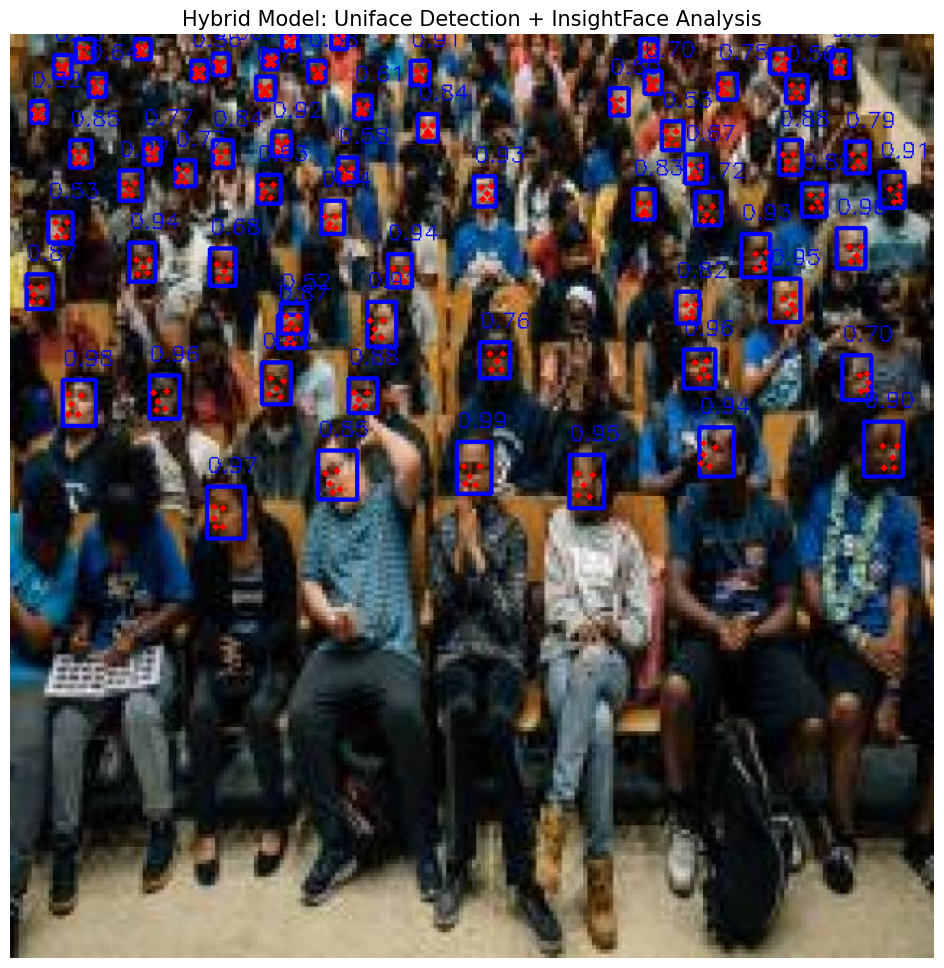

--- Face 1 ---
Predicted Age: 45
Predicted Gender: Male
Embedding vector size: 512
--- Face 2 ---
Predicted Age: 31
Predicted Gender: Male
Embedding vector size: 512
--- Face 3 ---
Predicted Age: 32
Predicted Gender: Male
Embedding vector size: 512
--- Face 4 ---
Predicted Age: 38
Predicted Gender: Male
Embedding vector size: 512
--- Face 5 ---
Predicted Age: 36
Predicted Gender: Male
Embedding vector size: 512
--- Face 6 ---
Predicted Age: 57
Predicted Gender: Male
Embedding vector size: 512
--- Face 7 ---
Predicted Age: 42
Predicted Gender: Male
Embedding vector size: 512
--- Face 8 ---
Predicted Age: 38
Predicted Gender: Male
Embedding vector size: 512
--- Face 9 ---
Predicted Age: 55
Predicted Gender: Male
Embedding vector size: 512
--- Face 10 ---
Predicted Age: 37
Predicted Gender: Male
Embedding vector size: 512
--- Face 11 ---
Predicted Age: 33
Predicted Gender: Male
Embedding vector size: 512
--- Face 12 ---
Predicted Age: 35
Predicted Gender: Male
Embedding vector size: 512
-

In [56]:
import matplotlib.pyplot as plt

# 1. Generate the annotated image using the compatible draw_faces function
# faces: the list of Face objects returned by app.get(img)
annotated_img = draw_faces(img, faces, color=COLORS['retina'])

# 2. Display the image
plt.figure(figsize=(20, 12))
# Convert BGR to RGB so colors appear correctly in the notebook
plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
plt.title("Hybrid Model: Uniface Detection + InsightFace Analysis", fontsize=15)
plt.axis('off')
plt.show()

# 3. (Optional) Print out the analysis results for each face found
for i, face in enumerate(faces):
    print(f"--- Face {i+1} ---")
    if hasattr(face, 'age'):
        gender_str = 'Male' if face.gender == 1 else 'Female'
        print(f"Predicted Age: {face.age}")
        print(f"Predicted Gender: {gender_str}")
    if hasattr(face, 'embedding'):
        print(f"Embedding vector size: {len(face.embedding)}")